## Women's E-Commerce Clothing Reviews

Prepared by Debora Callegari

### Imports

In [1]:
#Importing the necessary packages:

# Basic libraries
import numpy as np
import pandas as pd

# Graphs
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# WordCloud
from os import path
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Text preprocessing
import nltk
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Model and evaluation
from sklearn.model_selection import train_test_split

# Ignoring the warnings
import warnings
warnings.filterwarnings('ignore')

### Step 4: Using get dummies for categorical features

In [44]:
new_data.columns

Index(['clothing_id', 'age', 'title', 'review_text', 'rating',
       'recommended_ind', 'positive_feedback_count', 'division_name',
       'department_name', 'class_name'],
      dtype='object')

In [45]:
# Deciding which categorical features to use in model

for col_name in new_data.columns:
    if new_data[col_name].dtypes == 'object':
        unique = len(new_data[col_name].unique())
        print("Feature '{col_name}' has {unique} unique categories.".format(col_name=col_name, unique=unique))

Feature 'title' has 13984 unique categories.
Feature 'review_text' has 22621 unique categories.
Feature 'division_name' has 3 unique categories.
Feature 'department_name' has 6 unique categories.
Feature 'class_name' has 20 unique categories.


As we know, models can handle only numerical values. Considering the previous results, it is possible to see that for most of the features there are a lot of unique categories. In this case, it is not recommended to use dummies because it will increase the size of the data for categories that have few observations and can impact the results of the model. So, I decided to convert to numeric values the features 'division_name' and 'department_name'.

In [46]:
# Creating a list of features to dummy
dummy_list = ['division_name', 'department_name']

In [47]:
# Using function to dummy two categorical variables
def dummy_data(new_data, dummy_list):
    for x in dummy_list:
        dummies = pd.get_dummies(new_data[x], prefix=x, dummy_na=False)
        new_data = new_data.drop(x,1)
        new_data = pd.concat([new_data, dummies], axis=1)
    return new_data

In [48]:
clean_data = dummy_data(new_data, dummy_list)

In [49]:
clean_data.head()

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,class_name,division_name_General,division_name_General Petite,division_name_Intimates,department_name_Bottoms,department_name_Dresses,department_name_Intimate,department_name_Jackets,department_name_Tops,department_name_Trend
0,767,33,Null,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimates,0,0,1,0,0,1,0,0,0
1,1080,34,Null,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,1,0,0,0,1,0,0,0,0
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,Dresses,1,0,0,0,1,0,0,0,0
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,Pants,0,1,0,1,0,0,0,0,0
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,Blouses,1,0,0,0,0,0,0,1,0


In [50]:
clean_data.shape

(22628, 17)

Considering the shape of the dataset, after the process applied to get dummies over two categorical columns we can see that the number of features jumps from 10 to 17 in total.

### Step 5: Basic text preprocessing

##### 5.1. Review text column

In [51]:
clean_data['review_text'].describe()

count                                                 22628
unique                                                22621
top       Perfect fit and i've gotten so many compliment...
freq                                                      3
Name: review_text, dtype: object

The output below is showing six samples of the review text and the score for this review as well.

In [52]:
print(clean_data[['review_text', 'rating']].sample(6).values)

[['I am 5\'8" 140 lbs and the m fits perfectly. it is flowy and feminine but the tie in the back keeps it from looking boxy. pattern is really nice. great dress!'
  5]
 ['I purchased this dress in my normal small size - via online. i exchanged it it for a medium in the store as the shoulders were just a little too tight for me. i plan on wear it with tights/leggings as it\'s a little to short on my 5\'9" frame. well made and the bodice has so much detail but not over the top.'
  5]
 ['I saw this in the store and fell in love with it! i normally wear between a 29 and 30 in pants and the medium fit great. it is a very generous cut in the leg and the waist has an elastic band in the back. i\'m 5\'5" and the pants almost graze the top of my foot, perfect for sandals. if i had seen this stock photo first i would have been totally off-put by the culotte length, but i guess that\'s what it looks like on a model! there are cute buttons that run down the outside length of the pants and t'
  5]


In [53]:
clean_data[['review_text', 'rating']].groupby('rating').describe()

review_text                                                            \
             count unique                                                top   
rating                                                                         
1              821    821  I love this t-shirt because it has the combina...   
2             1549   1548  I purchased this and another eva franco dress ...   
3             2823   2823  I had to call so many stores to track this shi...   
4             4908   4908  I love this designer so i grabbed at this shir...   
5            12527  12521  Perfect fit and i've gotten so many compliment...   

             
       freq  
rating       
1         1  
2         2  
3         1  
4         1  
5         3

The output above is showing the description of text reviews by rating. It is possible to see that most of the reviews are unique as they appear only once in the dataset and only 5 text reviews showed more than once at the dataset. 

##### 5.1.1. Generating WordCloud

WordCloud is a good tool to visualize the frequency or importance of each word that is shown in the Review Text column. 

It is possible to see the positive experience from customers when we read, for example, the words 'love', 'nice' and 'really perfect'. Also, we can have the confirmation that 'top' and 'dress' are the products with the highest received reviews.

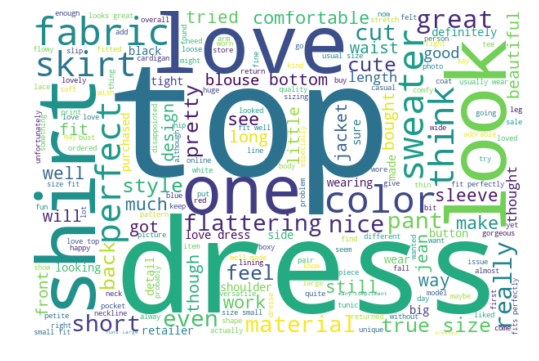

In [54]:
# Using wordcloud for review text column
text = clean_data['review_text'].str.cat(sep=' ')

# Creating and generating a wordcloud image
wordcloud = WordCloud(max_words=200, background_color='white', width=600, height=400, margin=0).generate(text)

# Displaying the image
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##### 5.1.2. Converting into Lower case

In this first section, I will transform all the content of the review text into lower case. It is a good approach to avoid several copies of the same words. We can see how the text looks like after applying the lower case code below.

In [55]:
clean_data['lower_review'] = clean_data['review_text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
clean_data['lower_review'].head()

0    absolutely wonderful - silky and sexy and comf...
1    love this dress! it's sooo pretty. i happened ...
2    i had such high hopes for this dress and reall...
3    i love, love, love this jumpsuit. it's fun, fl...
4    this shirt is very flattering to all due to th...
Name: lower_review, dtype: object

##### 5.1.3. Removing Stopwords and Punctuation

In [56]:
# Preparing to remove punctuation and stopwords
punctuations = string.punctuation
stop_words = set(stopwords.words('english'))

For this second section, I will remove all the punctuation and stopwords from the review text using predefined libraries found at nltk. This approach will be helpful to decrease the size of the dataset to modelling.

But before removing the stopwords from the data, I will calculate the number of stopwords, because it will permit extra information to identify how much we might have been losing before.

In [57]:
stopw_data = pd.DataFrame(clean_data['lower_review'])

In [58]:
stopw_data['stopwords_before'] = stopw_data['lower_review'].apply(lambda s: len([s for s in s.split() if s in stop_words]))
stopw_data[['lower_review','stopwords_before']].head()

,lower_review,stopwords_before
0,absolutely wonderful - silky and sexy and comf...,2
1,love this dress! it's sooo pretty. i happened ...,30
2,i had such high hopes for this dress and reall...,46
3,"i love, love, love this jumpsuit. it's fun, fl...",7
4,this shirt is very flattering to all due to th...,20


In [59]:
# Getting the total of stop_words 
Total = stopw_data['stopwords_before'].sum()
print (Total)

673161


Considering the previous output, it is good to know the total of the stopwords before applying the function.

I will define a function to remove all punctuation, stopwords and finally returns a string of the cleaned text review, as we can see below. 

In [60]:
def text_clean(review):
    """ 
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a string of the cleaned text review
    """
    texts = []
    
    # Checking the characters to see if there are any kind of punctuation
    no_punc = [char for char in review if char not in punctuations]

    # Joining the characters again to form the string
    no_punc = ''.join(no_punc)
    
    # Removing any stopwords
    tokens = [word for word in no_punc.split() if word.lower() not in stop_words]
    
    tokens1 = ' '.join(tokens)
    
    texts.append(tokens1)
    return pd.Series(texts)

### Step 6: Train - test split

As mentioned before, the problem that I am going to be tackling is to predict the scores of women's clothes based on text reviews. 

Firstly, I am not going to use all the features. After getting the results I can work on it and then start to consider feature selection for evaluating the models.

In [61]:
clean_data.head(2)

,clothing_id,age,title,review_text,rating,recommended_ind,positive_feedback_count,class_name,division_name_General,division_name_General Petite,division_name_Intimates,department_name_Bottoms,department_name_Dresses,department_name_Intimate,department_name_Jackets,department_name_Tops,department_name_Trend,lower_review
0,767,33,Null,Absolutely wonderful - silky and sexy and comf...,4,1,0,Intimates,0,0,1,0,0,1,0,0,0,absolutely wonderful - silky and sexy and comf...
1,1080,34,Null,Love this dress! it's sooo pretty. i happene...,5,1,4,Dresses,1,0,0,0,1,0,0,0,0,love this dress! it's sooo pretty. i happened ...


In [62]:
df = pd.DataFrame(clean_data[['lower_review', 'rating']])

In [63]:
df.head()

,lower_review,rating
0,absolutely wonderful - silky and sexy and comf...,4
1,love this dress! it's sooo pretty. i happened ...,5
2,i had such high hopes for this dress and reall...,3
3,"i love, love, love this jumpsuit. it's fun, fl...",5
4,this shirt is very flattering to all due to th...,5


In [64]:
# Applying the function 'text_clean'
df['clean_review'] = df['lower_review'].apply(text_clean)

In [65]:
df.head()

,lower_review,rating,clean_review
0,absolutely wonderful - silky and sexy and comf...,4,absolutely wonderful silky sexy comfortable
1,love this dress! it's sooo pretty. i happened ...,5,love dress sooo pretty happened find store im ...
2,i had such high hopes for this dress and reall...,3,high hopes dress really wanted work initially ...
3,"i love, love, love this jumpsuit. it's fun, fl...",5,love love love jumpsuit fun flirty fabulous ev...
4,this shirt is very flattering to all due to th...,5,shirt flattering due adjustable front tie perf...


In [66]:
# Seperating the dataset into X and y for prediction
X = df['clean_review']
y = df['rating']

In [67]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (22628,)
y shape: (22628,)


In [68]:
# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [69]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (18102,)
y_train shape: (18102,)
X_test shape: (4526,)
y_test shape: (4526,)


### Step 7: Converting Text to Numbers 

As we know, machines, as opposed to humans, and do not understand the raw text. 

Therefore, to proceed with this project I need to convert the text into numbers. Various approaches convert text into the corresponding numerical form. For this project, I will use Bag of Words.

#### 7.1. Bag of Words

In [70]:
# Creating CountVectorizer object
count_vect = CountVectorizer()

In [71]:
X_train_bow = count_vect.fit_transform(X_train)
X_train_bow = X_train_bow.toarray()

In [72]:
X_train_bow.shape

(18102, 17051)

In [73]:
X_test_bow = count_vect.transform(X_test).toarray()

In [74]:
X_test_bow.shape

(4526, 17051)

#### 7.1.1. Finding Term Frequency - Inverse Document Frequency (TF-IDF)

I will transform the X_train_bow that was created as bag-of-words into TF-IDF below.

In [75]:
# Creating TfidfTransformer object
tfidf_transformer = TfidfTransformer()

In [76]:
X_train_tfidf = tfidf_transformer.fit_transform(X_train_bow)
X_train_tfidf = X_train_tfidf.toarray()

In [77]:
X_train_tfidf.shape

(18102, 17051)

In [78]:
X_train_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [79]:
X_test_tfidf = tfidf_transformer.transform(X_test_bow).toarray()

In [80]:
X_test_tfidf.shape

(4526, 17051)

In [81]:
X_test_tfidf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])